In [78]:
import sys; sys.path.append('../util')
from load_yelp_data import load_yelp_dataframe, restaurants_and_bars_in, train_test_split_reviews
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import graphlab as gl
import sklearn.metrics
from baseline_calculator import *
import seaborn
%matplotlib inline

In [5]:
businesses = load_yelp_dataframe('businesses')
reviews = load_yelp_dataframe('reviews')
users = load_yelp_dataframe('users')
phoenix_restaurants, phoenix_reviews, phoenix_users = restaurants_and_bars_in('Phoenix', businesses, reviews, users)
reviews_train, reviews_test = train_test_split_reviews(phoenix_reviews)

In [125]:
def dfs_with_at_least_n_reviews(n):
    uids = users[users['review_count'] >= n].user_id.unique()
    df_train = reviews_train[reviews_train['user_id'].isin(uids)]
    df_test = reviews_test[reviews_test['user_id'].isin(uids)]
    return df_train, df_test
    
def sfs_with_at_least_n_reviews(n):
    df_train, df_test = dfs_with_at_least_n_reviews(n)
    sf_train = gl.SFrame(df_train[['business_id', 'user_id', 'stars']])
    sf_test = gl.SFrame(df_test[['business_id', 'user_id', 'stars']])
    return sf_train, sf_test

In [62]:
limits = list(range(1, 52, 5))
limits

[1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51]

In [126]:
train_pcts = []
test_pcts = []
for n in limits:
    df_train, df_test = dfs_with_at_least_n_reviews(n)
    train_pcts.append(len(df_train)/float(len(reviews_train)))
    test_pcts.append(len(df_test)/float(len(reviews_test)))

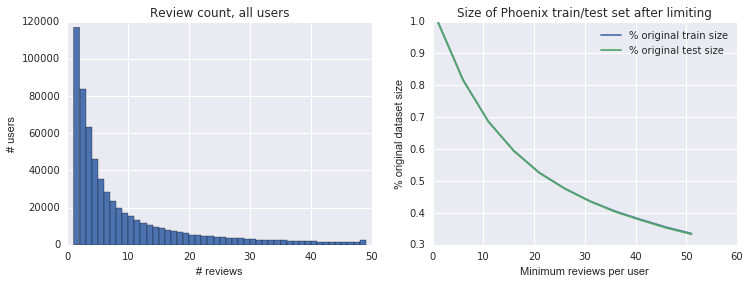

In [127]:
fig = plt.figure(figsize=(12,4))

fig.add_subplot(121)
plt.title('Review count, all users')
plt.hist(users['review_count'].values, bins=range(1,50))
plt.ylabel('# users')
plt.xlabel('# reviews')

fig.add_subplot(122)
plt.plot(limits, train_pcts, label='% original train size')
plt.plot(limits, test_pcts, label='% original test size')
plt.title('Size of Phoenix train/test set after limiting')
plt.xlabel('Minimum reviews per user')
plt.ylabel('% original dataset size')
plt.legend()
plt.show()

In [137]:
ambc = AbsoluteMeanBaselineCalculator()
ambc_rmses = []
for n in limits:
    df_train, df_test = dfs_with_at_least_n_reviews(n)
    ambc.fit(df_train)
    ambc_rmses.append(ambc.baseline_rmse(df_test))

In [128]:
sabc = SimpleAverageBaselineCalculator()
sabc_rmses = []
for n in limits:
    df_train, df_test = dfs_with_at_least_n_reviews(n)
    sabc.fit(df_train)
    sabc_rmses.append(sabc.baseline_rmse(df_test))

In [129]:
drbc = DecoupledRegularizedBaselineCalculator()
drbc_rmses = []
for n in limits:
    df_train, df_test = dfs_with_at_least_n_reviews(n)
    drbc.fit(df_train, busi_reg_strength=2.75, user_reg_strength=5.25)
    drbc_rmses.append(drbc.baseline_rmse(df_test))

In [130]:
mf_rmses = []
for n in limits:
    sf_train, sf_test = sfs_with_at_least_n_reviews(n)
    sub_rmses = []
    for l2, l1 in [(0.002,   0.0001),
                   (0.001,   0.0000875),
                   (0.00015, 0.000075)]:
        mf = gl.factorization_recommender.create(
            sf_train, item_id='business_id', target='stars', verbose=False,
            regularization=l2, linear_regularization=l1)
        sub_rmses.append(mf.evaluate_rmse(sf_test, target='stars')['rmse_overall'])
    mf_rmses.append(min(sub_rmses))

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

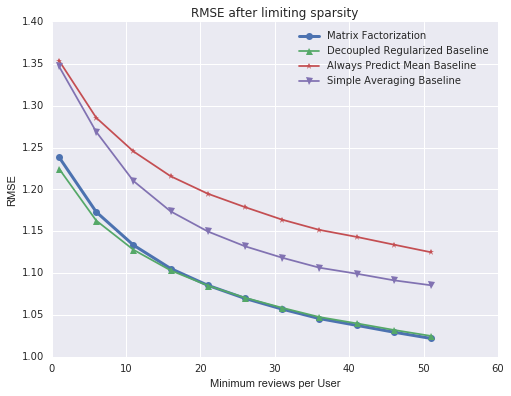

In [141]:
plt.figure(figsize=(8,6))
plt.plot(limits, mf_rmses, label='Matrix Factorization', lw=3, marker='o')
plt.plot(limits, drbc_rmses, label='Decoupled Regularized Baseline', marker='^')
plt.plot(limits, ambc_rmses, label='Always Predict Mean Baseline', marker='*')
plt.plot(limits, sabc_rmses, label='Simple Averaging Baseline', marker='v')
plt.xlabel('Minimum reviews per User')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.title('RMSE after limiting sparsity')
plt.show()

In [132]:
print limits

[1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51]


In [133]:
print mf_rmses

[1.2385633311722528, 1.1730685163212553, 1.1334851168205469, 1.105463166256838, 1.085405073594499, 1.0697390875999702, 1.0569642065904663, 1.0456526403242428, 1.0376083358051706, 1.0294414191540957, 1.0219716280158133]


In [134]:
print drbc_rmses

[1.2247480610519876, 1.1627825513023182, 1.1279161123630423, 1.1032374006578436, 1.0851554008286375, 1.0705908035986496, 1.0585416108583765, 1.0474821825009051, 1.0399449858756995, 1.0320956006814908, 1.0249059749287748]


In [135]:
print sabc_rmses

[1.3469914912875001, 1.2688261532628602, 1.2100876446803808, 1.1737717303634438, 1.1497290846789949, 1.1320384508624415, 1.1183700903034743, 1.1064513384933774, 1.0992805814510733, 1.0913887905270954, 1.0854447998250942]


In [139]:
print ambc_rmses

[1.3539247525181541, 1.2856227810361816, 1.2454333926492431, 1.2157618826109751, 1.194847490523091, 1.1788216896903068, 1.1638168542298035, 1.1516208518403999, 1.1432594776401821, 1.1340076921925879, 1.1249051865015114]
